In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.cm as cm

In [2]:
#!pip install yellowbrick

In [3]:
import matplotlib.style as style
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# Exemplo de excução do Kmeans
### import numpy as np
### X = np.array([[1, 2,3], [1, 4,5], [1, 0,3],[5, 2,4], [10, 4,5], [10, 0,8]])
### kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X)

In [4]:
path = 'dados/notasParaClusterizacao2019.csv'

In [5]:
notasEnem = pd.read_csv(path,sep=';',encoding='latin1',low_memory=False)


In [6]:
notasEnem

,RendaMaxima,NU_NOTA_MT,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_CN,NU_NOTA_REDACAO
0,0,505.6,507.4,528.2,408.4,620.0
1,2495,469.1,463.5,504.9,372.2,700.0
2,2994,486.3,455.5,520.6,503.9,560.0
3,1497,418.1,427.6,488.5,410.8,440.0
4,998,466.7,436.9,470.9,443.6,260.0
...,...,...,...,...,...,...
6743,1996,467.2,405.4,532.7,422.6,500.0
6744,0,426.9,474.6,500.3,438.4,480.0
6745,998,499.7,501.2,460.9,396.0,480.0
6746,1497,519.2,579.2,590.2,557.4,880.0


### Calculando a coluna notas média

In [7]:
col = notasEnem.loc[: , "NU_NOTA_MT":"NU_NOTA_REDACAO"]
df = col
notasEnem['mediaNota'] = col.mean(axis=1)
col = notasEnem.loc[: , "NU_NOTA_MT":"NU_NOTA_REDACAO"]




In [8]:
col.values

array([[505.6, 507.4, 528.2, 408.4, 620. ],
       [469.1, 463.5, 504.9, 372.2, 700. ],
       [486.3, 455.5, 520.6, 503.9, 560. ],
       ...,
       [499.7, 501.2, 460.9, 396. , 480. ],
       [519.2, 579.2, 590.2, 557.4, 880. ],
       [582.5, 508. , 565.4, 551.3, 880. ]])

# Transformando base com Quantile Transformer

In [11]:
scaler = preprocessing.QuantileTransformer(n_quantiles=5, random_state=19)
X = scaler.fit_transform(col.values)


# Calculando o melhor valor de K, salva em um arquivos TesteNumClusters

In [12]:
import time
oldTime = time.time()

range_n_clusters = [2,3,4,5,6,7,8,9,10]

range_seeds=[13]

bestSilhouette = 0;
bestK= 0;
Results = {
    "K" : [],
    "time" : [],
    "S": [],
    "seed": []
}

for seed in range_seeds:
    for n_clusters in range_n_clusters:
        time_1 = time.time()
        # Create a subplot with 1 row and 2 columns
              # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init='random', random_state=seed,max_iter=1200)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        #print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
        
        time_2 = time.time() - time_1 
        
        Results["K"].append(n_clusters)
        Results["S"].append(silhouette_avg)
        Results["seed"].append(seed)
        Results["time"].append(time_2)

        if(silhouette_avg > bestSilhouette ):
            bestSilhouette = silhouette_avg
            bestK = n_clusters
            bestCluster = cluster_labels
        
    print("For n_clusters =", bestK,
              " The best silhouette_score is :", bestSilhouette, " Seed:", seed)   
       


For n_clusters = 2  The best silhouette_score is : 0.4670993147136718  Seed: 13


In [13]:
# Printa o tempo total que levou, para curiosidade 
resultados = pd.DataFrame(Results)
resultados.to_csv("Dados/TesteNumClusters.csv")

new_time = time.time() - oldTime

print(new_time)

13.990423679351807


In [14]:
resultados = pd.read_csv("Dados/TesteNumClusters.csv")

In [15]:
silhouette_scores = resultados['S']

### O Gráfico a seguir é gerado com as diversas silhuetas calculadas

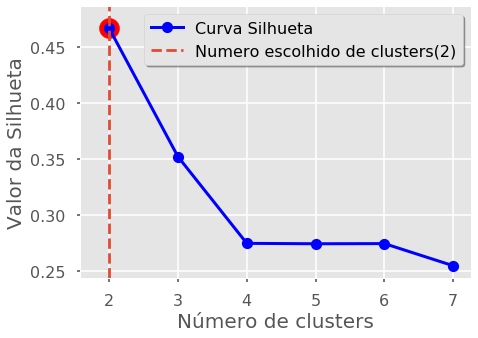

In [17]:
silhouette_scores = silhouette_scores[:6]

ax = plt.subplots(figsize=(7, 5))
plt.plot(range(2,8),silhouette_scores,"bo-",color="blue",linewidth=3,label="Curva Silhueta")
t = plt.xlabel("Número de clusters")
text = plt.ylabel("Valor da Silhueta")
p = plt.xticks([2,3,4,5,6,7,8])

k = np.argmax(silhouette_scores) + 2

plt.axvline(x=k,linestyle="--",label="Numero escolhido de clusters({})".format(k))

plt.scatter(k,silhouette_scores[k-2],c="red",s=400)

plt.legend(shadow=True)
text.set_fontsize(20)
t.set_fontsize(20)
plt.savefig("Gráficos/CurvaSilhueta")

plt.show()

### Aplicando normalização com QuantileTransformer
### Aplicando Algoritmo Kmeans com K=2 e calculando silhueta

In [19]:
import time
oldTime = time.time()

clusterer = KMeans(n_clusters=bestK,random_state=13,max_iter=1200,init='random')
cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)

labels = pd.DataFrame(clusterer.labels_)
notasEnem['Cluster'] = labels[0]
print(notasEnem.groupby("Cluster")['mediaNota'].describe())
print(notasEnem['Cluster'].value_counts()) 


print(silhouette_avg)

elapsed = time.time() - oldTime;

print("Time: ", elapsed)


          count        mean        std     min     25%     50%     75%     max
Cluster                                                                       
0        3135.0  634.426054  60.184647  499.66  585.92  627.22  678.13  845.00
1        3613.0  474.140720  44.538452  336.70  441.70  476.18  509.04  583.56
1    3613
0    3135
Name: Cluster, dtype: int64
0.4670993147136718
Time:  0.8935792446136475


For n_clusters = 2 The average silhouette_score is : 0.4670993147136718


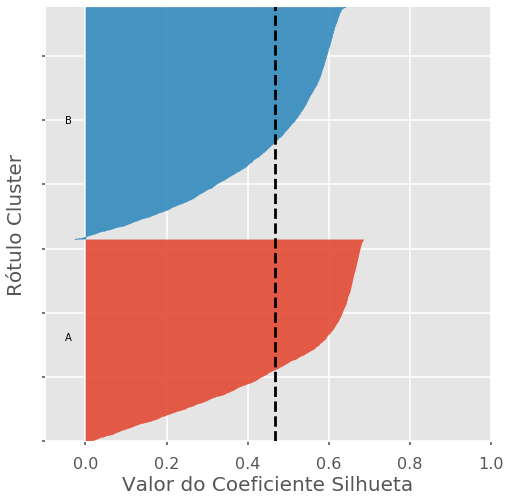

In [25]:
range_n_clusters = [2]


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
  
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    ax1 = fig.add_subplot()

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters,  random_state=seed,init='random',max_iter=1200)
   # cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
  #  silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", bestSilhouette)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    rotulos = ["A","B"]
    colors = [(0.8862745098039215, 0.2901960784313726, 0.2),(0.20392156862745098, 0.5411764705882353, 0.7411764705882353)]
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, rotulos[i])

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("Plotagem da silhueta para os clusters")
    t = ax1.set_xlabel("Valor do Coeficiente Silhueta")
    text = ax1.set_ylabel("Rótulo Cluster")
    ax1.set_yticklabels([""])
    ax1.figure.savefig("Gráficos/Silhueta")
    text.set_fontsize(20)
    t.set_fontsize(20)
    
     # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="black", linestyle="--")
    

   

  
   

  

plt.show()

### Printa em 3D as dimensôes (0,1,4) Ciências Humanas, Matemática e Redação 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
    
# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#colors = [(0.8862745098039215, 0.2901960784313726, 0.2), (0.20392156862745098, 0.5411764705882353, 0.7411764705882353)]
ax2.scatter(X[:, 0], X[:,1], X[:, 4], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')
    
# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 4], marker='o', c="red", alpha=1, s=80)

#for i, c in enumerate(centers):
#    ax2.scatter(c[0], c[1], c[4], marker='X', alpha=1,
#                    s=10000, edgecolor='k')

ax2.set_title("Visualização 3D dos dados agrupados.")
ax2.set_xlabel("Nota Matemática")
ax2.set_ylabel("Nota Redação")
ax2.set_zlabel("Nota Ciências Humanas")
ax2.set_xticklabels("")
ax2.set_yticklabels("")
ax2.set_zticklabels("")

ax2.figure.savefig("Gráficos/Clusterizacao3D")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
labels = pd.DataFrame(clusterer.labels_)
notasEnem['Cluster'] = labels[0]
notasEnem['Cluster'].value_counts() 

notasEnem['mediaNota'] = round(notasEnem['mediaNota'])


In [ ]:
path = "Dados/dadosParaMineracaoRegrasAssociacao2019.csv"

dadosEnem = pd.read_csv(path,sep=';',encoding='latin1',low_memory=False)

In [ ]:

dadosEnem["Cluster"] = notasEnem["Cluster"]

dadosEnem.to_csv("agrupadas_notas_normalizadoQuantil.csv",sep=";")


## Usando algoritmo de mineração de regras de associação

### Não foi usado para o artigo, recomendo utilizar a ferramenta Orange (mais fácil para isso conforme indicado no README

In [ ]:
!pip install apyori
from apyori import apriori

In [ ]:
path = "agrupadas_notas_normalizadoQuantil"

dadosEnemClusterizados = pd.read_csv(path,sep=';',encoding='latin1',low_memory=False,index_col=0)

In [ ]:
dadosEnemClusterizados

In [ ]:
records = []
for i in range(0,dadosEnem.shape[0]):
    records.append([str(dadosEnem.values[i,j]) for j in range(0, dadosEnem.shape[1] )])

In [ ]:
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]



In [ ]:
newRecords = []
for record in records:
    record = remove_values_from_list(record,"0")
    newRecords.append(record)

In [ ]:
dadosParaMineracao = pd.DataFrame(newRecords);
#dadosParaMineracao.to_csv("dadosEnemParaAssociacao.csv",sep=";")

In [ ]:
association_rules = apriori(newRecords, min_support=0.15, min_confidence=0.4, min_lift=3, min_length=2)


In [ ]:
association_results = list(association_rules)



In [ ]:
association_rules

In [ ]:
for item in association_results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")